In [1]:
import numpy as np
import os
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import xgboost as xgb
import matplotlib.pyplot as plt # for plotting
%matplotlib widget
import seaborn as sns # for plotting
import pandas as pd # for data manipulation
from Models.load_data import *
import random

%load_ext autoreload
%autoreload 2

In [3]:
# Load the shot data and replace nans with zeros to get arrays of equal length
path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\Training_data_NO_dtIPLA_conv'
features_list = os.listdir(os.path.join(path, r'features'))
features_sequence = ['SSXcore', 'IPLA', 'DAO_EDG7', 'RNT', 'DAI_EDG7', 'ECE_PF']
# Replace 'path' and 'features_list' with your actual base path and list of feature file names.
#X_train, y_train, X_test, y_test, x_mini_test, y_mini_test = load_all_data(path, features_list, features_sequence = features_sequence)


features_sequence_w = ['SSXcore', 'IPLA', 'DAO_EDG7', 'RNT', 'DAI_EDG7', 'ECE_PF', 'dtIPLA']
# Load the shot data and replace nans with zeros to get arrays of equal length
path_w = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\Training_data_w_dtIP_conv'
features_list_w = os.listdir(os.path.join(path_w, r'features'))

In [4]:
# Removing features that are not in both datasets
not_sim = []
for feature in features_list:
    if feature not in features_list_w:
        print(feature)
        features_list.pop(features_list.index(feature))
len(not_sim)

mixed_feature_list = features_list
random.shuffle(features_list) # Shuffle the list of files to avoid bias

In [5]:
X_train, y_train, X_test, y_test, x_mini_test, y_mini_test = load_all_data(path, features_list, features_sequence = features_sequence)
X_train_w, y_train_w, X_test_w, y_test_w, x_mini_test_w, y_mini_test_w = load_all_data(path_w, features_list, features_sequence = features_sequence_w)

Key ECE_PF not in JETno94507.csv. Filling it with zeros.
Key ECE_PF not in JETno95136.csv. Filling it with zeros.
Key ECE_PF not in JETno90644.csv. Filling it with zeros.
Key ECE_PF not in JETno100176.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno80853.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno80848.csv. Filling it with zeros.
Key RNT not in JETno98938.csv. Filling it with zeros.
Key ECE_PF not in JETno99275.csv. Filling it with zeros.
Key ECE_PF not in JETno98083.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno82257.csv. Filling it with zeros.
Key ECE_PF not in JETno97441.csv. Filling it with zeros.
Key RNT not in JETno95072.csv. Filling it with zeros.
Key ECE_PF not in JETno94496.csv. Filling it with zeros.
Key ECE_PF not in JETno91888.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno83235.csv. Filling it with zeros.
Key ECE_PF not in JETno94357.csv. Filling it with zeros.
Key ECE_PF not in JETno89439.csv. Filling it with zeros.
Key ECE_PF not in JETno94507

C:\Users\Max Tost\AppData\Local\Temp\ipykernel_11892\2551058722.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(x/max(np.absolute(x)), label = label)


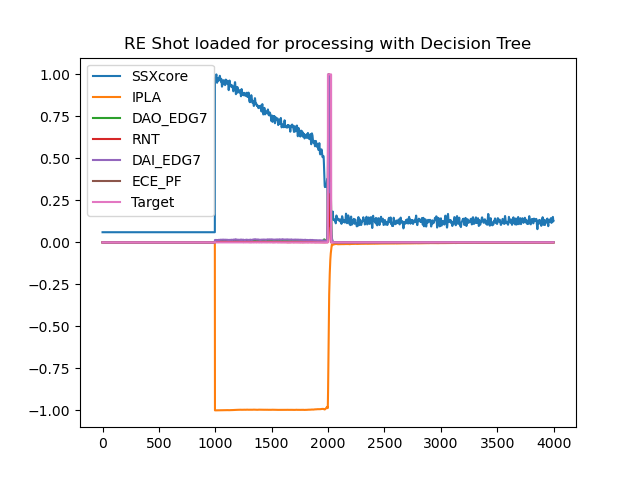

In [6]:
re_index = np.where(y_train == 1)[0][1]
# Validation that data conversion worked: positive
x_re = X_train[re_index-2000:re_index+2000, :].T
y_re = y_train[re_index-2000:re_index+2000]
plt.close()
for x, label in zip(x_re, features_sequence):
    plt.plot(x/max(np.absolute(x)), label = label)
plt.plot(y_re.T, label='Target')
plt.title(f'RE Shot loaded for processing with Decision Tree')
plt.legend()

C:\Users\Max Tost\AppData\Local\Temp\ipykernel_11892\1170744176.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(x/max(np.absolute(x)), label = label)


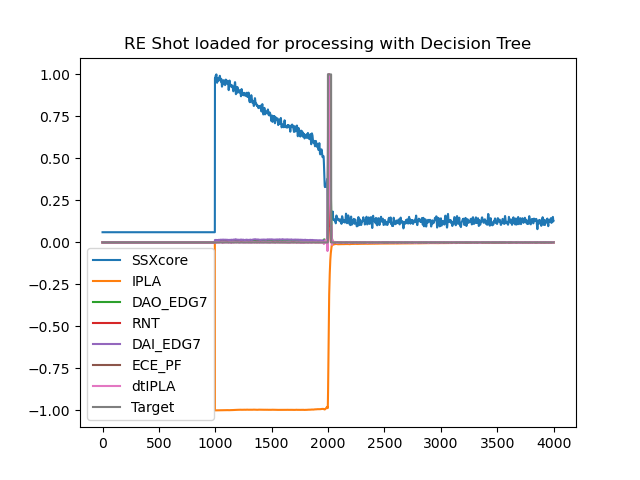

In [7]:
re_index = np.where(y_train_w == 1)[0][1]
# Validation that data conversion worked: positive
x_re = X_train_w[re_index-2000:re_index+2000, :].T
y_re = y_train_w[re_index-2000:re_index+2000]
plt.close()
for x, label in zip(x_re, features_sequence_w):
    plt.plot(x/max(np.absolute(x)), label = label)
plt.plot(y_re.T, label='Target')
plt.title(f'RE Shot loaded for processing with Decision Tree')
plt.legend()

In [8]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE with a fixed random_state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE only on the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res_w, y_train_res_w = smote.fit_resample(X_train_w, y_train_w)

print('Before resampling the minority class, counts of appearences of 1 and 0 respectively')
print(len(np.where(y_train==1)[0]), len(np.where(y_train==0)[0]))
print('After oversampling the minority class')
print(len(np.where(y_train_res==1)[0]), len(np.where(y_train_res==0)[0]))

Before resampling the minority class, counts of appearences of 1 and 0 respectively
8881 393120
After oversampling the minority class
393120 393120


In [9]:
# Convert the data into DMatrix for both datasets with and without dtIPLA
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)
d_mini_test = xgb.DMatrix(x_mini_test, label=y_mini_test)
dtrain_w = xgb.DMatrix(X_train_res_w, label=y_train_res_w)
dtest_w = xgb.DMatrix(X_test_w, label=y_test_w)

In [10]:
# Set parameters for binary classification
#{'eta': 0.16846576192352627, 'max_depth': 18, 'min_child_weight': 2, 'num_rounds': 101}
params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": 0.168465761923526272,
        "max_depth": 18,
        "min_child_weight": 2,
        "subsample": 0.9136547225140513,
        "colsample_bytree": 0.7982666062021071,
        "scale_pos_weight": 1.139133758423292
    }



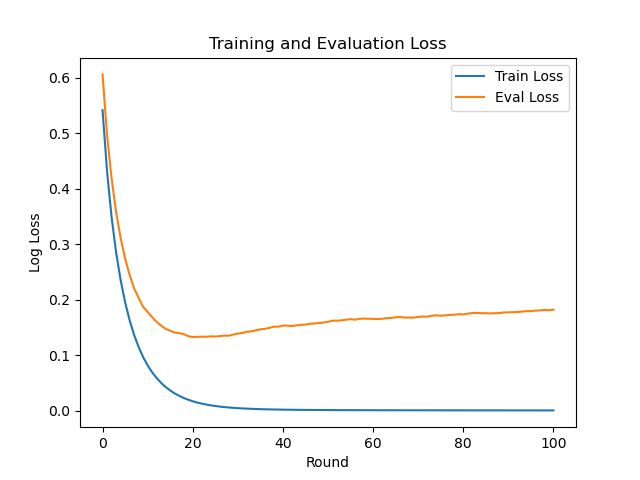

No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm: 1b1d10a4e865474998b8bfdfb16f4ec8
No such comm:

In [11]:
num_rounds = 101
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model and record the evaluation results
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=num_rounds, evals=evals, evals_result=evals_result, verbose_eval=False)

# Save the evaluation results
for round_num in range(num_rounds):
    train_loss = evals_result['train']['logloss'][round_num]
    eval_loss = evals_result['eval']['logloss'][round_num]

# Plot the loss values
plt.close()
plt.plot(evals_result['train']['logloss'], label='Train Loss')
plt.plot(evals_result['eval']['logloss'], label='Eval Loss')
plt.xlabel('Round')
plt.ylabel('Log Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()
plt.savefig(rf'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Models\XGBoost_loss_no_dtIP.svg', format='svg')

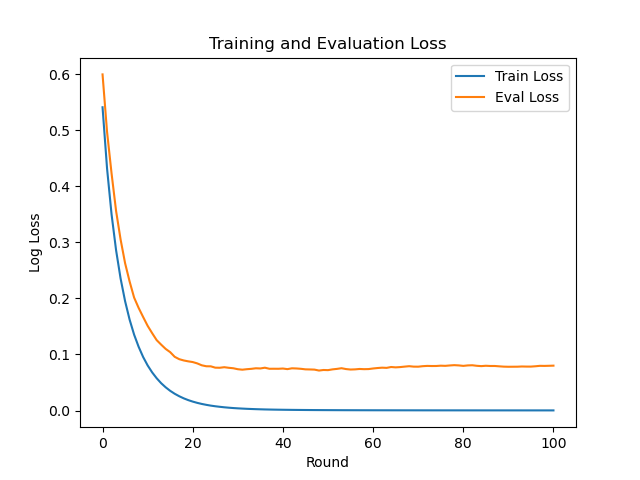

In [12]:
num_rounds = 101
evals_w = [(dtrain_w, 'train'), (dtest_w, 'eval')]

# Train the model and record the evaluation results
evals_result_w = {}
bst_w = xgb.train(params, dtrain_w, num_boost_round=num_rounds, evals=evals_w, evals_result=evals_result_w, verbose_eval=False)

# Save the evaluation results
for round_num in range(num_rounds):
    train_loss_w = evals_result_w['train']['logloss'][round_num]
    eval_loss_w = evals_result_w['eval']['logloss'][round_num]

# Plot the loss values
plt.close()
plt.plot(evals_result_w['train']['logloss'], label='Train Loss')
plt.plot(evals_result_w['eval']['logloss'], label='Eval Loss')
plt.xlabel('Round')
plt.ylabel('Log Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()
plt.savefig(rf'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Models\XGBoost_loss_w_dtIP.svg', format='svg')

## Predictions with model trained on no dtIP

In [13]:
# Predict the train dataset without dt IPLA
y_pred = bst.predict(dtrain)

# Predict the test dataset without dt IPLA
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_train_res, y_pred_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    393120
         1.0       1.00      1.00      1.00    393120

    accuracy                           1.00    786240
   macro avg       1.00      1.00      1.00    786240
weighted avg       1.00      1.00      1.00    786240



In [14]:
# Predict on the test of the dataset without dtIPLA
y_pred = bst.predict(dtest)

# Convert probabilities to binary labels (assuming binary classification)
y_pred_labels = (y_pred > 0.5).astype(int)


print(classification_report(y_test, y_pred_labels, digits=5))

              precision    recall  f1-score   support

         0.0    0.99792   0.95496   0.97597    103469
         1.0    0.48136   0.95454   0.63998      4531

    accuracy                        0.95494    108000
   macro avg    0.73964   0.95475   0.80798    108000
weighted avg    0.97625   0.95494   0.96187    108000



## Predictions on model trained with dtIP

In [15]:
# predict on the trainin set of the dataset with dtIPLA
y_pred_w = bst_w.predict(dtrain_w)

# Convert probabilities to binary labels (assuming binary classification)
y_pred_labels_w = (y_pred_w > 0.5).astype(int)

print(classification_report(y_train_res_w, y_pred_labels_w, digits=5))

              precision    recall  f1-score   support

         0.0    1.00000   0.99999   0.99999    393120
         1.0    0.99999   1.00000   0.99999    393120

    accuracy                        0.99999    786240
   macro avg    0.99999   0.99999   0.99999    786240
weighted avg    0.99999   0.99999   0.99999    786240



In [16]:
# predict on the test of the dataset with dtIPLA
y_pred_w = bst_w.predict(dtest_w)

# Convert probabilities to binary labels (assuming binary classification)
y_pred_labels_w = (y_pred_w > 0.5).astype(int)

print(classification_report(y_test_w, y_pred_labels_w, digits=5))

              precision    recall  f1-score   support

         0.0    0.99863   0.97473   0.98654    103469
         1.0    0.62686   0.96954   0.76142      4531

    accuracy                        0.97451    108000
   macro avg    0.81274   0.97213   0.87398    108000
weighted avg    0.98304   0.97451   0.97709    108000



## Parameter Optimization

In [14]:
import optuna # 
import xgboost as xgb
from sklearn.metrics import f1_score


def objective(trial):
    # Define the hyperparameter search space

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": trial.suggest_float("eta", 0.001, 0.3, log=True),  # Log scale for learning rate
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": 0.9136547225140513,
        "colsample_bytree": 0.7982666062021071,
        "scale_pos_weight": 1.139133758423292
    }

    num_rounds = trial.suggest_int("num_rounds", 10, 150)

    bst = xgb.train(params, dtrain, num_rounds)

    # Predict on the test set
    y_mini_pred_labels = bst.predict(d_mini_test)

    # Assuming y_test and y_pred_labels are already defined
    f1 = f1_score(y_mini_test, (y_mini_pred_labels > 0.5).astype(int))
    
    return f1

# Paus hints for the report
# How I labeled the shots
# Splitting of data
# Composition of training and test data
# Performance with correct settings
# Time derivative of plasma current as extra and compare results
# Usually: Wrong parameters stops learning after few epochs, 

In [15]:
# Create a study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best hyperparameters
best_num_rounds = best_params.pop("num_rounds")
bst = xgb.train(best_params, dtrain, num_boost_round=best_num_rounds)

# Predict on the test set
y_pred = bst.predict(dtest)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_labels)
print(f"F1 Score: {f1:.2f}")

[I 2025-02-08 10:20:53,222] A new study created in memory with name: no-name-527168df-b70f-4d3a-9745-5f54ab3a087e
[I 2025-02-08 10:21:12,261] Trial 0 finished with value: 0.39183954549367306 and parameters: {'eta': 0.014027774846193558, 'max_depth': 22, 'min_child_weight': 20, 'num_rounds': 71}. Best is trial 0 with value: 0.39183954549367306.
[I 2025-02-08 10:21:16,289] Trial 1 finished with value: 0.229652292973174 and parameters: {'eta': 0.04037967676424936, 'max_depth': 6, 'min_child_weight': 6, 'num_rounds': 21}. Best is trial 0 with value: 0.39183954549367306.
[I 2025-02-08 10:21:54,161] Trial 2 finished with value: 0.4036822164338148 and parameters: {'eta': 0.013332077298863189, 'max_depth': 21, 'min_child_weight': 17, 'num_rounds': 95}. Best is trial 2 with value: 0.4036822164338148.
[I 2025-02-08 10:22:33,096] Trial 3 finished with value: 0.269083866802948 and parameters: {'eta': 0.0011286764475045357, 'max_depth': 15, 'min_child_weight': 11, 'num_rounds': 146}. Best is trial 

Best hyperparameters: {'eta': 0.16846576192352627, 'max_depth': 18, 'min_child_weight': 2, 'num_rounds': 101}
Accuracy: 0.95
F1 Score: 0.06


In [178]:
# Calculate accuracy
y_pred = bst.predict(dtest)
y_pred_labels = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_labels)
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.95
F1 Score: 0.07
